Importing the libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from google.colab import drive
import random

drive.mount('/content/drive')

Mounted at /content/drive


Redirecting the dataset from the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_dir = '/content/drive/MyDrive/ASSESMENT_TRIMESTER_001/DNN_ASSESMENT_PROJECT_TRIMESTER_001'

algonauts_dir = 'algonauts_2023_tutorial_data' # Path to the shortcut in your drive
reduced_images_dir = 'reduced_images_algonauts' # Path to the shortcut in your drive

# Loading reduced images
reduced_images = np.load( os.path.join(root_dir, reduced_images_dir, 'subj01', 'images.npy') )

Mounted at /content/drive/


## Pre-defined functions

The following functions can be used to load the FMRI data from a given subject, load activity from a given region of interest or loading the corresponding image.

In [3]:
# Loads all the fmri data associated to a given subject
def load_fmri_of_subject( subj, hemisphere, directory = root_dir ):
  subj = subj # Subject
  hemisphere = hemisphere # Which side of the brain
  # Listing directory
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
  return brain_activity

# Loads the data associated to a specific part of the brain (Some will be empty, it varies by subject)
def load_fmri_region_of_interest( subj, roi, hemisphere, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
    # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'

  # Loading the roi masks (To locate the activations of a given region)
  roi_class_dir = os.path.join(data_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
  roi_map_dir = os.path.join(data_dir, 'roi_masks',
      'mapping_'+roi_class+'.npy')
  roi_class_idx = np.load(roi_class_dir)
  roi_map = np.load(roi_map_dir, allow_pickle=True).item()
  roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
  challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

  # Selection the appropriate data
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

  fmri_roi_data = brain_activity[:,np.where(challenge_roi)[0]]

  return fmri_roi_data

# Load a particular image from a subject
def load_image_subject( subj, img, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
  test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
  train_img_list = os.listdir(train_img_dir)
  train_img_list.sort()
  test_img_list = os.listdir(test_img_dir)
  test_img_list.sort()

  img_dir = os.path.join(train_img_dir, train_img_list[img])
  train_img = Image.open(img_dir).convert('RGB') # Image library (PIL)
  return train_img

def load_reduced_image_subject( subj, img, directory = root_dir ):
  image = reduced_images[img]

  return Image.fromarray(image)


# Brain Activity

The next cells show you how to read some of the data. Explore the data structures so that you feel comfortable with them. First, start by getting familiar with the brain activations. What is their range? How do they change for different images?

(9841, 20544)


<BarContainer object of 2 artists>

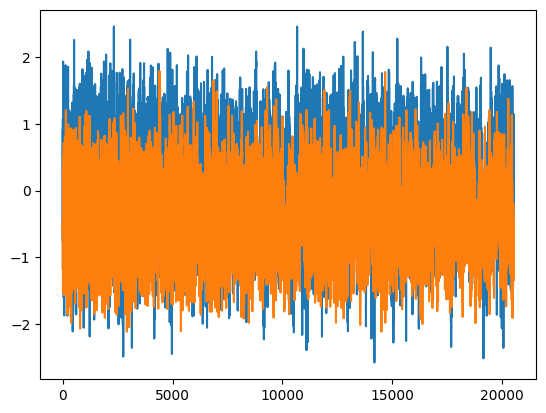

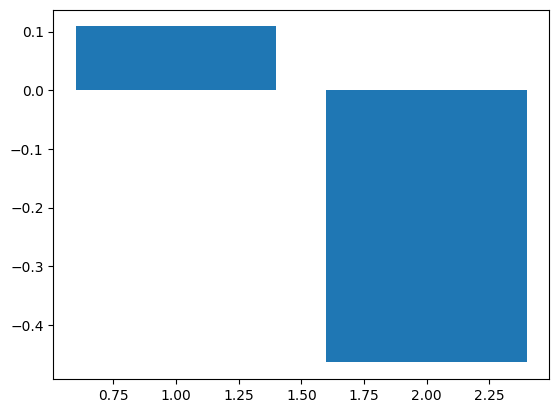

In [4]:
brain_activity = load_fmri_of_subject( subj = 1, hemisphere = 'right') # Images x activations

print(brain_activity.shape) # Images x brain activty
img1 = 340
img2 = 560
plt.plot(brain_activity[img1, :]) # Normalized (Z-Score)
plt.plot(brain_activity[img2, :])

plt.figure()
activation1 = np.mean(brain_activity[img1, :])
activation2 = np.mean(brain_activity[img2, :])
plt.bar((1, 2), (activation1, activation2))

## Selecting a particular ROIs

You can be more accurate by selecting, from the total number of activations (voxels), those belonging to a particular regions. Those activations correspond to a particular location in the brain that has some functions significance:


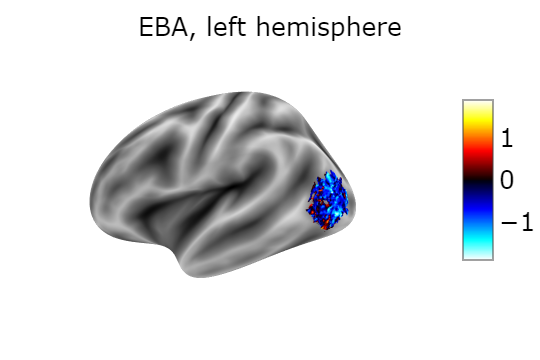:


In [5]:
roi = "V1d"
fmri_roi_data = load_fmri_region_of_interest( subj = 1, roi = roi, hemisphere = 'left' ) # Images x roi_data
print(fmri_roi_data.shape)

(9841, 828)


## Loading the images

**Full size images**

Compare the activations and the images side-by-side, do you find any interesting patterns? what about different regions of interest, do they show differences?

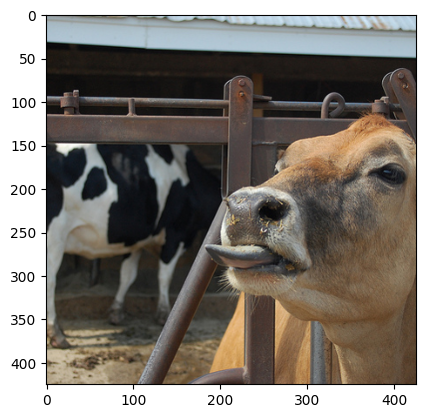

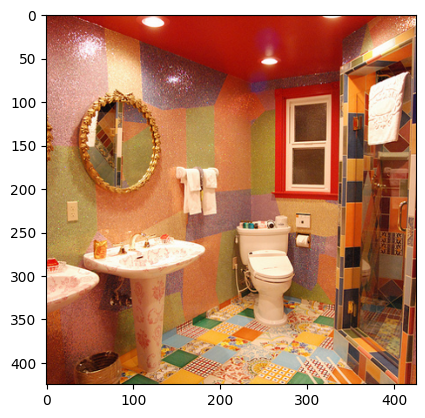

In [6]:

train_img = load_image_subject( subj = 1, img = 430 ) # Loading the images corresponding to the data shown before
plt.imshow(train_img)
plt.figure()
train_img = load_image_subject( subj = 1, img = 450 ) # Loading the images corresponding to the data shown before
plt.imshow(train_img)

**64x64 reduced images**


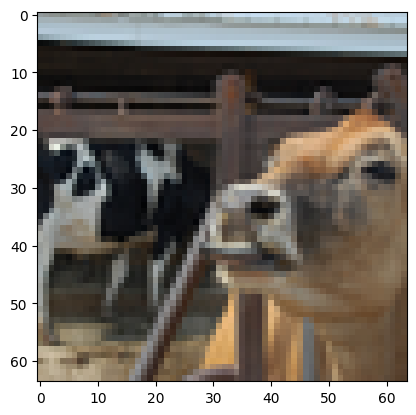

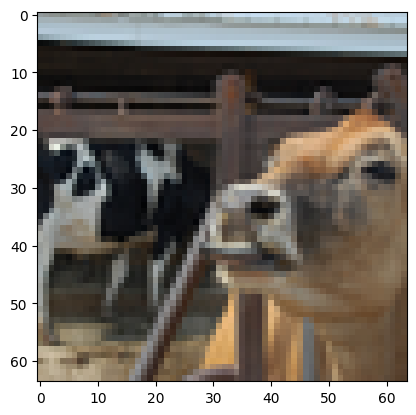

In [9]:
train_img = load_reduced_image_subject( subj = 1, img = 430 ) # Loading the images corresponding to the data shown before
plt.imshow(train_img)
plt.figure()
train_img = load_reduced_image_subject( subj = 1, img = 430 ) # Loading the images corresponding to the data shown before
plt.imshow(train_img)

# CREATING THE DECODER

In [8]:
# This dataset provides batches of image, brain activity, pairs
class BrainDataSet(Dataset):
  def __init__( self, subject, hemisphere, transform = None ):
    self.subject = subject # We need to select a particular object
    self.hemisphere = hemisphere
    self.fmri_data = load_fmri_of_subject( subject, hemisphere ) # Load all the data from the subjects
    self.data_len, self.num_samples = self.fmri_data.shape # Get the shape MxN
    self.transform = transform

  def __len__(self):
    return self.data_len # len is the total number of images

  def __getitem__( self, idx ):
    # Get FMRI data
    x = self.fmri_data[idx, :]
    # Obtain images
    img = load_reduced_image_subject( subj = self.subject, img = idx ) # This is slow. If you can you should preload all images
    return self.transform(img) if self.transform else img, torch.from_numpy(x),


subject = 1 # change this to change the subject
hemisphere = 1 # change this to change the hemisphere (1 left, 2 right)
# You define to define a transform:
# 1. Convert the images to Tensors
# 2. Resize (32, 32)
# 3. Normalize
resize_normalize = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize((32,32)), # We downsample the images a lot. Bigger images take more time to train
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset
myDataset = BrainDataSet( subject, hemisphere, resize_normalize)

# Creating the train loader

In [10]:
def showImage( ax, image, title = '' ):
  ''' This is a helper function that allows you to show the results of your training '''
  image = (image - torch.min(image))/(torch.max(image)-torch.min(image)) # image 0...1
  ax.imshow(image.permute(1,2,0)) # You need reorganize the dimension (3, H,  W) -> (H, W, 3)
  ax.set_title(title)

# Creating a data loader
# Shuffles
# Organizes in batches
train_loader = DataLoader( dataset = myDataset,
                          #  num_workers = 2, # Parallel to make it faster
                          #  prefetch_factor=16, # This is used to preload some of the data
                           batch_size = 32,
                           shuffle = True )

# Training the Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        c_hid = base_channel_size  # Base channel size (e.g., 32)
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            nn.BatchNorm2d(2 * c_hid),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * c_hid),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            nn.BatchNorm2d(2 * c_hid),
            act_fn(),
            nn.Conv2d(2 * c_hid, 4 * c_hid, kernel_size=3, padding=1),  # Additional layer
            nn.BatchNorm2d(4 * c_hid),
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),  # One more additional layer
            nn.BatchNorm2d(4 * c_hid),
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(4 * 16 * c_hid, latent_dim),  # Adjusted to match additional layers
        )

    def forward(self, x):
        return self.net(x)

The decoder is just the encoder inverted:

In [12]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        c_hid = base_channel_size  # Base channel size (e.g., 32)
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 16 * c_hid),  # Adjusted to match additional layers
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),  # Additional layer
            nn.BatchNorm2d(4 * c_hid),
            act_fn(),
            nn.ConvTranspose2d(4 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 4x4 => 8x8
            nn.BatchNorm2d(2 * c_hid),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * c_hid),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),  # 16x16 => 32x32
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)  # Reshape to grid
        x = self.net(x)
        return x

We put everything together in our autoencoder network:

In [13]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = 32,
        height: int = 32,
    ):
        super().__init__()
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x) # Latent code
        x_hat = self.decoder(z) # Reconstruction
        return x_hat


## **Training the autoencoder**

If you decide to train the autoencoder again (because you are making some changes to it OR because you chose a different subject, set the variable TRAIN to True

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN = False

In [15]:
def train_autoencoder():
  ''' Helper function that trains the autoencoder '''
  PATH = 'autoencoder.pt'
  learning_rate = 1e-3
  criterion = nn.MSELoss() # Explore loss functions

  amodel = Autoencoder(base_channel_size = 32, latent_dim = 512)  # =====  Changes made from 64 into 512  =========== 128
  amodel = amodel.to(device)
  optimizer = torch.optim.Adam(amodel.parameters(), lr = learning_rate)
  epochs = 80

  Losses_mean = np.zeros(epochs) # We store the mean loss to plot
  Losses_std = np.zeros(epochs) # We also might want to desplay the standard deviation

  for i in range(epochs):
    current_losses = [] # We store the single losses of every epoch to average at the end

    for k, (x, y) in enumerate(train_loader):
      x = x.to(device)
      x_rec = amodel(x)

      loss = criterion(x, x_rec) # Are the image and the reconstruction the same?
      current_losses += [loss.item()]

      if np.mod(k, 100) == 0:
        print( f'epoch: {i}, loss: {loss.item()}' )

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    Losses_mean[i] = np.mean(np.array(current_losses))
    Losses_std[i] = np.std(np.array(current_losses))
    # Saving checkpoint
    torch.save({
              'epoch': i,
              'model_state_dict': amodel.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': Losses_mean[i],
              }, PATH) # Save checkpoint

  model_save_name = 'final_autoencoder.pt'
  path = F"/content/drive/MyDrive/{model_save_name}"
  torch.save(amodel.state_dict(), path) # Save the final weights

  return amodel, Losses_mean, Losses_std

# NOTE: Overfitting is OK, so no test set or validation (for our case)

if TRAIN:
  amodel, loss_mean, loss_std = train_autoencoder()
  plt.plot( loss_mean )
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Autoencoder training loss')
else:
  amodel = Autoencoder(base_channel_size = 32, latent_dim = 64)
  # I provided some pretrained weights
  model_save_name = 'final_autoencoder.pt'
  path = os.path.join("/content/drive/MyDrive/", model_save_name)  
  amodel.load_state_dict(torch.load(path)) # Load from the absolute path

amodel.to(device)
amodel.eval()

**Testing the trained autoencoder**

Try to come up with a measure of the quality of the reconstruction!

epoch: 0, loss: 2.013727903366089
epoch: 0, loss: 0.6479623317718506
epoch: 0, loss: 0.46304845809936523
epoch: 0, loss: 0.42964571714401245
epoch: 1, loss: 0.4494379162788391
epoch: 1, loss: 0.4245170056819916
epoch: 1, loss: 0.3779848515987396
epoch: 1, loss: 0.3473546504974365
epoch: 2, loss: 0.41066306829452515
epoch: 2, loss: 0.3032997250556946
epoch: 2, loss: 0.3528707027435303
epoch: 2, loss: 0.3485034704208374
epoch: 3, loss: 0.3143252730369568
epoch: 3, loss: 0.28088152408599854
epoch: 3, loss: 0.2657674252986908
epoch: 3, loss: 0.24970027804374695
epoch: 4, loss: 0.2897056043148041
epoch: 4, loss: 0.2856878638267517
epoch: 4, loss: 0.3117258548736572
epoch: 4, loss: 0.27052542567253113
epoch: 5, loss: 0.23521646857261658
epoch: 5, loss: 0.2255733460187912
epoch: 5, loss: 0.2181602120399475
epoch: 5, loss: 0.20650534331798553
epoch: 6, loss: 0.20320388674736023
epoch: 6, loss: 0.2153477519750595
epoch: 6, loss: 0.18015699088573456
epoch: 6, loss: 0.217943474650383
epoch: 7, lo

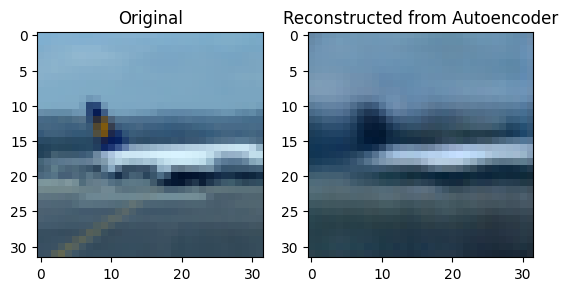

In [16]:
amodel, Losses_mean, Losses_std = train_autoencoder()
# First get a sample image from the loader
image, activity = next(iter(train_loader))
# We move it to the GPU (if available)
image = image.to(device)
# We get the output of the autoencoder, which should be very similar to the image
reconstructed_image = amodel(image)
# Plot the result
fig, ax = plt.subplots(1, 2)
showImage(ax[0], image.to('cpu')[0,:, :, :], title = 'Original')
showImage(ax[1], reconstructed_image.to('cpu').detach()[0,:, :, :], title = 'Reconstructed from Autoencoder')


## **Creating a decoder from the brain activity**

Now we create a personalized neural network that replaces the encoder in our autoencoder. We called brain decoder because it translates brain signals into latent vectors.

In [17]:
# ***************************************************************************
# You need to define your own brain decoder
# You take the brain activity as input and the "Encoder" latent activity as output
# ****************************************************************************
class BrainDecoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
        super(BrainDecoder, self).__init__()
        H1 = hidden_size
        H2 = 2000
        H3 = 1000
        H4 = 500
        self.fc1 = nn.Linear(input_size, H1)
        self.bn1 = nn.BatchNorm1d(H1)  # ===== Added layers for batch normalization ==============
        self.fc2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(H3)
        self.fc4 = nn.Linear(H3, H4)
        self.bn4 = nn.BatchNorm1d(H4)
        self.fc5 = nn.Linear(H4, output_size)  # ============= Final layer mapping to latent dimension ==================
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)  # ============== Add dropout for regularization =====================

  def forward(self, x): # x is activity
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.fc5(out)  # layers added according to the output of the encoder
        return out

# Your code here
# The input size is the size of the vector of the brain activity
image, activity = next(iter(train_loader))
size_brain_activity = activity.shape[1] # Because shape of activity is 16xSIZE_BRAIN_ACTIVTY!!!!
latent_dimension = 512
myBrainDecoder = BrainDecoder( input_size = size_brain_activity, hidden_size = 3000, output_size = latent_dimension )
myBrainDecoder.to(device)

BrainDecoder(
  (fc1): Linear(in_features=20544, out_features=3000, bias=True)
  (bn1): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=3000, out_features=2000, bias=True)
  (bn2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2000, out_features=1000, bias=True)
  (bn3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1000, out_features=500, bias=True)
  (bn4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=500, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

**Train your decoder**  (CLASS TUTORIAL WITH SMALL ALTERATIONS)

In [21]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(myBrainDecoder.parameters(), lr = learning_rate)
criterion = nn.MSELoss() # Try different losses
epochs = 85

Losses_mean = np.zeros(epochs) # We store the mean loss to plot
Losses_std = np.zeros(epochs) # We also might want to desplay the standard deviation

for i in range(epochs):
  current_losses = [] # We store the single losses of every epoch to average at the end

  for k, (x, brain_activity) in enumerate(train_loader):
    # First compute the output of the encoder from the image
    x = x.to(device)
    brain_activity = brain_activity.to(device)
    latent_code = amodel.encoder(x) # This is the encoder from the autoencode
    # Get the brain activity associated to that image and compute the out of the brain decoder
    y = myBrainDecoder(brain_activity) # !!!!
    # Compare output to the latent code
    loss = criterion(y, latent_code) # Are the image and the reconstruction the same?
    current_losses += [loss.item()]

    if np.mod(k, 500) == 0:
        print( f'epoch: {i}, loss: {loss.item()}' )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Finished epoch
  Losses_mean[i] = np.mean(np.array(current_losses))
  Losses_std[i] = np.std(np.array(current_losses))
  torch.save({
              'epoch': i,
              'model_state_dict': amodel.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': Losses_mean[i],
              }, '/content/drive/MyDrive/brain_decoder.pt') # Save checkpoint

# TO-DO: Plot the loss (see the training of the autoencoder for ideas on how to do it)

epoch: 0, loss: 13.814872741699219
epoch: 1, loss: 13.085453033447266
epoch: 2, loss: 11.899263381958008
epoch: 3, loss: 11.585738182067871
epoch: 4, loss: 12.31141471862793
epoch: 5, loss: 12.453376770019531
epoch: 6, loss: 12.317461967468262
epoch: 7, loss: 10.934117317199707
epoch: 8, loss: 11.695838928222656
epoch: 9, loss: 10.828697204589844
epoch: 10, loss: 11.576766014099121
epoch: 11, loss: 10.620220184326172
epoch: 12, loss: 10.285768508911133
epoch: 13, loss: 10.56507682800293
epoch: 14, loss: 10.791252136230469
epoch: 15, loss: 9.955703735351562
epoch: 16, loss: 10.135815620422363
epoch: 17, loss: 9.787496566772461
epoch: 18, loss: 9.937519073486328
epoch: 19, loss: 9.29789924621582
epoch: 20, loss: 8.961824417114258
epoch: 21, loss: 9.419601440429688
epoch: 22, loss: 9.304574966430664
epoch: 23, loss: 8.580881118774414
epoch: 24, loss: 9.747796058654785
epoch: 25, loss: 8.758916854858398
epoch: 26, loss: 10.06773567199707
epoch: 27, loss: 8.693421363830566
epoch: 28, loss: 

Text(0, 0.5, 'Loss')

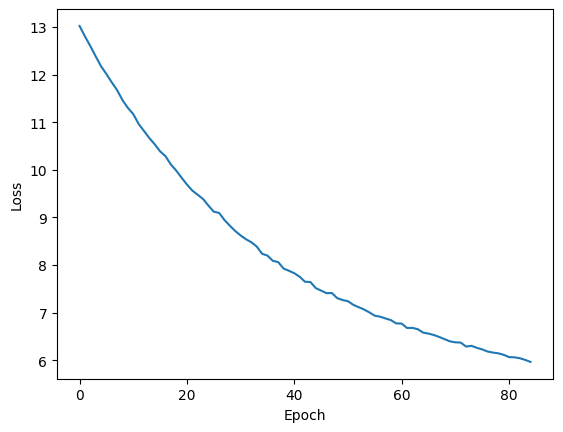

In [22]:
# Plotting loss

plt.plot(Losses_mean)
plt.xlabel('Epoch')
plt.ylabel('Loss')

##**Reconstructing images from brain activity.**

Now that we have trained our brain decoder, we can try to reconstruct the image from brain activity.

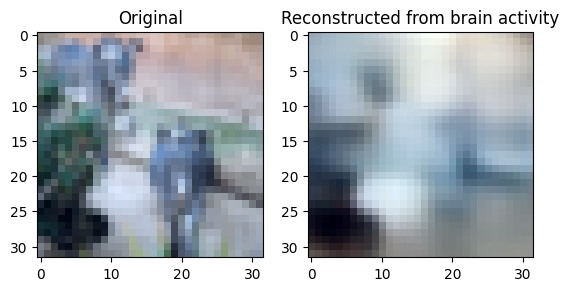

In [23]:
# First you get the brain activity from train loader
image, brain_activity = next(iter(train_loader))
# Second you poss it through you BrainDecoder
z_brain = myBrainDecoder(brain_activity.to(device))
# Third you pass z_brain (latent code) thorugh the decoder of the autoencoder
reconstructed_image = amodel.decoder(z_brain)
reconstructed_image = reconstructed_image.detach().to('cpu')
fig, ax = plt.subplots(1,2)
showImage(ax[0], image[0, :, :, :], title = 'Original')
showImage(ax[1], reconstructed_image[0, :, :, :], 'Reconstructed from brain activity')


#Individual Implementation for the improvement (Training the decoder based on left and right halves) - UPDATED

In [24]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(myBrainDecoder.parameters(), lr = learning_rate)
criterion = nn.MSELoss() # Try different losses
epochs_100 = 100

Losses_mean_100 = np.zeros(epochs_100) # We store the mean loss to plot
Losses_std = np.zeros(epochs_100) # We also might want to desplay the standard deviation


#Splitting the brain decoder into two parts to improve concentration

# Let's consider left and right brain decoders

brain_left = brain_activity[:, :brain_activity.shape[1] // 2]
brain_right = brain_activity[: , brain_activity.shape[1] // 2:]

# ========= we already have this logic in the top ===========================================
# myBrainDecoder = BrainDecoder( input_size = size_brain_activity, hidden_size = 3000, output_size = latent_dimension )
# myBrainDecoder.to(device)

# ================= Splitting the decoder ==================

myBrainDecoder_left = BrainDecoder( input_size = brain_left.shape[1], hidden_size = 3000, output_size = latent_dimension // 2 )
myBrainDecoder_left.to(device)

myBrainDecoder_right = BrainDecoder( input_size = brain_right.shape[1], hidden_size = 3000, output_size = latent_dimension // 2 )
myBrainDecoder_right.to(device)

# =================================== OPTIMIZERS FOR THE DECODERS  ========================================

optimizer = torch.optim.Adam(list(myBrainDecoder_left.parameters())+list(myBrainDecoder_right.parameters()), lr = learning_rate)
# optimizer_right = torch.optim.Adam(myBrainDecoder_right.parameters(), lr = learning_rate)

# Training the decoders

for i in range(epochs_100):
  current_los = []


  for k, (x, brain_activity) in enumerate(train_loader):
    x = x.to(device)
    brain_activity = brain_activity.to(device)

    # splitting the brain activity into two
    brain_left = brain_activity[:, :brain_activity.shape[1] // 2]
    brain_left = brain_left.to(device)
    brain_right = brain_activity[: , brain_activity.shape[1] // 2:]
    brain_right = brain_right.to(device)

    # as the above the latent code is

    latent_code = amodel.encoder(x)


    # Compare output to the latent code
    predict_left = myBrainDecoder_left(brain_left)
    predict_right = myBrainDecoder_right(brain_right)

    #predictions = predict_left + predict_right
    predictions = torch.cat((predict_left, predict_right), dim=1)

    # Loss computation

    loss = criterion(predictions, latent_code)
    loss_left = criterion(predict_left, latent_code[:, :latent_code.shape[1] // 2])
    loss_right = criterion(predict_right, latent_code[:, latent_code.shape[1] // 2:])


    # Backpropagation

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Tracking the losses

    cur_loss = loss.item()


    if np.mod(k, 500) == 0:
        print( f'epoch: {i}, loss: {loss_left.item(), loss_right.item()}' )

  Losses_mean_100[i] = np.mean(np.array(cur_loss))
  Losses_std[i] = np.std(np.array(cur_loss))

print("Completed the decoder training")







epoch: 0, loss: (43.09369659423828, 42.21040344238281)
epoch: 1, loss: (34.05235290527344, 36.78033447265625)
epoch: 2, loss: (33.75337219238281, 33.52197265625)
epoch: 3, loss: (32.379268646240234, 32.471649169921875)
epoch: 4, loss: (31.507993698120117, 31.64142608642578)
epoch: 5, loss: (33.042442321777344, 32.736358642578125)
epoch: 6, loss: (29.80038833618164, 29.701374053955078)
epoch: 7, loss: (30.154991149902344, 28.577606201171875)
epoch: 8, loss: (29.937416076660156, 29.792274475097656)
epoch: 9, loss: (28.073102951049805, 28.489765167236328)
epoch: 10, loss: (29.101882934570312, 30.151329040527344)
epoch: 11, loss: (27.056171417236328, 28.793987274169922)
epoch: 12, loss: (27.614025115966797, 28.3226375579834)
epoch: 13, loss: (24.19901466369629, 24.764873504638672)
epoch: 14, loss: (25.700637817382812, 26.149349212646484)
epoch: 15, loss: (25.35559844970703, 26.082897186279297)
epoch: 16, loss: (23.83359718322754, 24.971607208251953)
epoch: 17, loss: (25.398273468017578, 26

Average loss of the brain decoder

Text(0, 0.5, 'Loss')

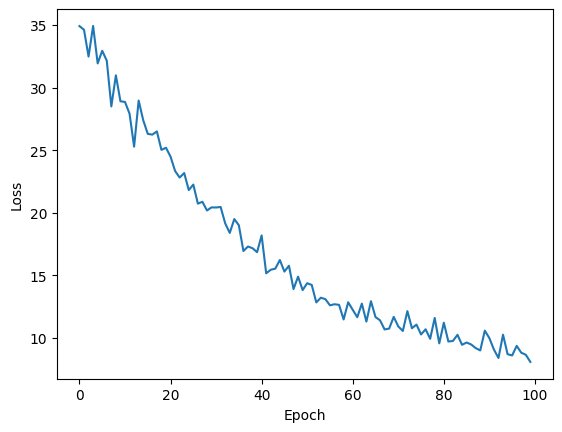

In [25]:
# Plotting loss

plt.plot(Losses_mean_100)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [26]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(myBrainDecoder.parameters(), lr = learning_rate)
criterion = nn.MSELoss() # Try different losses
epochs_60 = 60

Losses_mean_60 = np.zeros(epochs_60) # We store the mean loss to plot
Losses_std = np.zeros(epochs_60) # We also might want to desplay the standard deviation


#Splitting the brain decoder into two parts to improve concentration

# Let's consider left and right brain decoders

brain_left = brain_activity[:, :brain_activity.shape[1] // 2]
brain_right = brain_activity[: , brain_activity.shape[1] // 2:]

# ========= we already have this logic in the top ===========================================
# myBrainDecoder = BrainDecoder( input_size = size_brain_activity, hidden_size = 3000, output_size = latent_dimension )
# myBrainDecoder.to(device)

# ================= Splitting the decoder ==================

myBrainDecoder_left = BrainDecoder( input_size = brain_left.shape[1], hidden_size = 3000, output_size = latent_dimension // 2 )
myBrainDecoder_left.to(device)

myBrainDecoder_right = BrainDecoder( input_size = brain_right.shape[1], hidden_size = 3000, output_size = latent_dimension // 2 )
myBrainDecoder_right.to(device)

# =================================== OPTIMIZERS FOR THE DECODERS  ========================================

optimizer = torch.optim.Adam(list(myBrainDecoder_left.parameters())+list(myBrainDecoder_right.parameters()), lr = learning_rate)

# Training the decoders

for i in range(epochs_60):
  current_los = []


  for k, (x, brain_activity) in enumerate(train_loader):
    x = x.to(device)
    brain_activity = brain_activity.to(device)

    # splitting the brain activity into two
    brain_left = brain_activity[:, :brain_activity.shape[1] // 2]
    brain_left = brain_left.to(device)
    brain_right = brain_activity[: , brain_activity.shape[1] // 2:]
    brain_right = brain_right.to(device)

    # as the above the latent code is

    latent_code = amodel.encoder(x)


    # Compare output to the latent code
    predict_left = myBrainDecoder_left(brain_left)
    predict_right = myBrainDecoder_right(brain_right)

    #predictions = predict_left + predict_right
    predictions = torch.cat((predict_left, predict_right), dim=1)

    # Loss computation

    loss = criterion(predictions, latent_code)
    loss_left = criterion(predict_left, latent_code[:, :latent_code.shape[1] // 2])
    loss_right = criterion(predict_right, latent_code[:, latent_code.shape[1] // 2:])


    # Backpropagation

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Tracking the losses

    cur_loss = loss.item()


    if np.mod(k, 500) == 0:
        print( f'epoch: {i}, loss: {loss_left.item(), loss_right.item()}' )

  Losses_mean_60[i] = np.mean(np.array(cur_loss))
  Losses_std[i] = np.std(np.array(cur_loss))

print("Completed the decoder training")


epoch: 0, loss: (41.395591735839844, 41.15119934082031)
epoch: 1, loss: (34.878753662109375, 36.65188217163086)
epoch: 2, loss: (33.38678741455078, 34.91900634765625)
epoch: 3, loss: (34.32611846923828, 34.94245910644531)
epoch: 4, loss: (33.39218521118164, 33.692909240722656)
epoch: 5, loss: (30.996585845947266, 30.421106338500977)
epoch: 6, loss: (29.123741149902344, 28.533145904541016)
epoch: 7, loss: (30.96910285949707, 31.610736846923828)
epoch: 8, loss: (29.15530014038086, 29.444807052612305)
epoch: 9, loss: (30.02695655822754, 27.840307235717773)
epoch: 10, loss: (27.905200958251953, 28.535770416259766)
epoch: 11, loss: (28.80638885498047, 29.198867797851562)
epoch: 12, loss: (26.538127899169922, 27.928634643554688)
epoch: 13, loss: (25.55325698852539, 25.732505798339844)
epoch: 14, loss: (25.76367950439453, 26.52349090576172)
epoch: 15, loss: (25.339954376220703, 25.678573608398438)
epoch: 16, loss: (23.967632293701172, 24.31990623474121)
epoch: 17, loss: (24.393388748168945, 2

Text(0, 0.5, 'Loss')

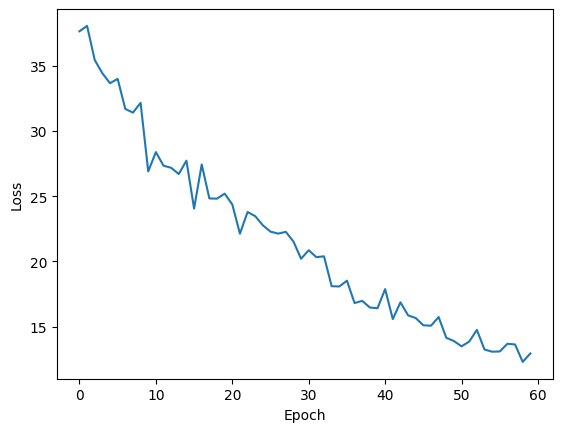

In [27]:
# Plotting loss

plt.plot(Losses_mean_60)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Loss Comparison Between 100 and 60 Epochs')

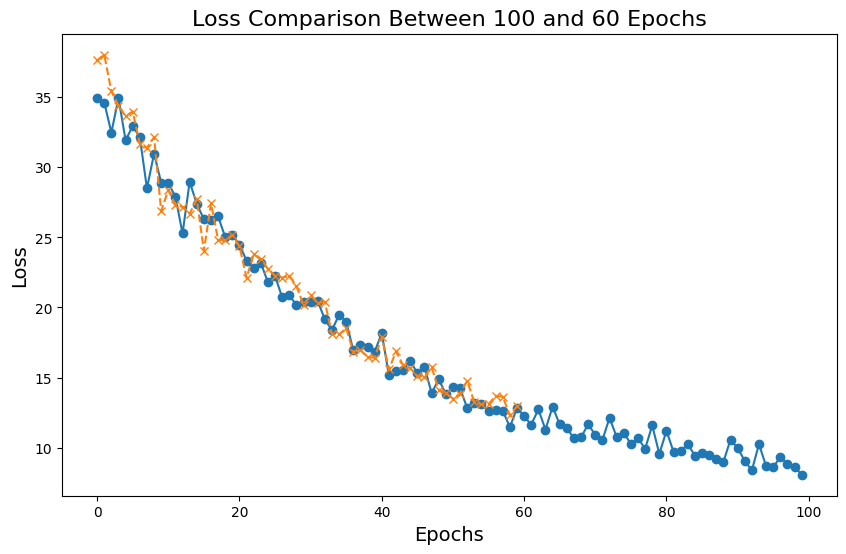

In [28]:
# Comparing the plots

plt.figure(figsize=(10, 6))

# Plot for 100 epochs
plt.plot(range(epochs_100), Losses_mean_100, label="100 Epochs", linestyle='-', marker='o')

# Plot for 60 epochs
plt.plot(range(epochs_60), Losses_mean_60, label="60 Epochs", linestyle='--', marker='x')


plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Loss Comparison Between 100 and 60 Epochs", fontsize=16)

Image Reconstruction

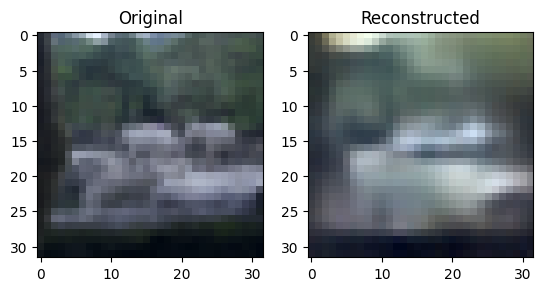

In [29]:
# Get brain activity
image, brain_activity = next(iter(train_loader))

# Split brain activity into two halves
brain_activity_left = brain_activity[:, :brain_activity.shape[1] // 2].to(device)
brain_activity_right = brain_activity[:, brain_activity.shape[1] // 2:].to(device)

# Decoding left and right brain activities
z_brain_left = myBrainDecoder_left(brain_activity_left)
z_brain_right = myBrainDecoder_right(brain_activity_right)

# Concatenate latent codes
z_brain = torch.cat((z_brain_left, z_brain_right), dim=1)

# Reconstruct image
reconstructed_image = amodel.decoder(z_brain)
reconstructed_image = reconstructed_image.detach().to('cpu')

# Visualization
fig, ax = plt.subplots(1, 2)
showImage(ax[0], image[0, :, :, :], title='Original')
showImage(ax[1], reconstructed_image[0, :, :, :], title='Reconstructed')
